In [1]:
import forecast_engine.preprocess.nodes as preprocess
import pandas as pd
import forecast_engine.modelling.utils.nodes as utils
import warnings
warnings.filterwarnings("ignore")

Sales Order

In [2]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Sales order"
sales_data, df = preprocess.read_prep_sales_order(path)
dates, act_dates = preprocess.prep_dates_list(df)
sub_season = [str(x)+'_Season' for x in dates]
df[sub_season] = df.apply( lambda x : preprocess.decomposition(x,dates,df.columns), axis = 1, result_type="expand")
df['intermittence'] = df.apply(lambda x : preprocess.intermittence(x), axis =1)
df['cov'] = df[dates].apply(lambda x : preprocess.cov(x), axis =1)
df['seq - flag'] = df.apply(lambda x : preprocess.seq_flag(x,dates,df.columns) , axis = 1)

Weather

In [6]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Weather Data/Weather Data.xlsx"
wthr_data = preprocess.read_prep_weather(path)

Macro

In [7]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Macro-economics"
macro = preprocess.read_macro_files(path, country = ['Mexico'])

In [8]:
df['Country'] = 'Mexico'
data = pd.merge(df, macro, on = 'Country', how = 'left')
data = pd.merge(data, wthr_data, on = 'Country', how = 'left')
data.drop('Country',axis=1,inplace=True)
data.rename(columns={'Material':'index'},inplace=True)
data.columns = [str(i) for i in list(data.columns) ]
    

In [9]:
ti = data[data['index']=='U00000000006030126'].squeeze(axis=0)
from pandas import MultiIndex
import datetime 
single_series = 0
ts1 = datetime.datetime.now().timestamp()
if (single_series == 0):
  ti = pd.Series(ti)
series_key = str(ti['index'])
ti1, ti_key, variable_list, series_flag = utils.get_ti_in_shape(ti.copy())
ti = ti1.copy()
ts2 = datetime.datetime.now().timestamp()
ti=ti1.copy()
ti = ti[2:]
ti['Material'] = ti_key[0]
ti['seq - flag'] = series_flag
ti['key'] = ti['Material'] +"_"+ ti['Header']
ti_key

index            U00000000006030126
intermittence                   0.0
cov                        0.798933
Name: 474, dtype: object

Inventory

In [228]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Inventory data"
inventories = preprocess.read_process_inventories(path)

LA0005 Inventory FY21-22.xlsx,(923, 30)
LA0005 Inventory FY22-23.xlsx,(5808, 6)
LA0005 Inventory FY19-20.xlsx,(9408, 6)
LA0005 Inventory FY18-19.xlsx,(4080, 6)
LA0005 Inventory FY20-21.xlsx,(12372, 6)


In [229]:
inventories
df_in = pd.DataFrame(columns=['Material','date','Qty Total\nStock','Total Stk Value','year','month','version','key','qty lag 1','val lag 1', 'qty lag 2','val lag 2'])
for i in list(inventories['Material'].unique()):
    df = inventories[inventories['Material']==i]
    df['qty lag 1'] = df['Qty Total\nStock'].shift(1)
    df['val lag 1'] = df['Total Stk Value'].shift(1)
    df['qty lag 2'] = df['Qty Total\nStock'].shift(2)
    df['val lag 2'] = df['Total Stk Value'].shift(2)
    df_in = pd.concat([df_in,df])
df_in = df_in.reset_index(drop=True)    
df_in.to_csv('inventories.csv')

Transaction

In [166]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Transaction data/"
trans = preprocess.read_process_trans(path)

Customer Master

In [12]:
path = r"/Users/anand_k/Downloads/UPL/Demand forecasting datasets [DO NOT EDIT]/Customer Data/Customer_data_All.xlsx"
customer = pd.read_excel(path, sheet_name='Sheet1')
customer = customer[['Customer','Domestic vs Export']].drop_duplicates()

Crop Seasonality

In [4]:
#TODO: Prepare the crop data and update the seasonality attribute

FEATURE TO CREATE

In [6]:
# 1 Lag of prices - Done
# 2 Number of days from order and delivery - Done
# 3 Customer demand trend level shifts #TODO
# 4 Customer region (for a material - year_month, where the order is coming from) - Done
# 5 Average number of days diff to each region - Done
# 6 Average sold quatity to each region - Done
# 7 Change in quantity from previous month #TODO
# 8 Change in quantity from previous 2 months #TODO
# 9 Change in quantity from previous 3 months #TODO
# 10 Seasonal crops - Needs more time #TODO
# 11 Disruption flags - Done
# 12 Inventory trend lag - Done
# 13 Inventory seasonality - Done
# 14 Quantity pending - Done


# In 1 sales order a customer can buy multiple materials
# Same custmor ID can have multiple sales order
# sales order - material year-month customer


In [25]:
cus_sales = pd.merge(sales_data,customer.drop_duplicates(subset='Customer', keep="first"),left_on='Bill-to party',right_on='Customer')
sales_data.shape[0] == cus_sales.shape[0]

True

In [50]:
feature_4 = cus_sales.groupby(['Material','Domestic vs Export','version'])['Sales document'].size().reset_index().pivot(index=["Material",'version'],columns='Domestic vs Export',values='Sales document').reset_index().rename_axis(None, axis=1).fillna(0)
feature_4.head(2)

#TODO metl & pivot

,Material,version,Arysta LifeScience,Exp Sales ALS Benelu,Exports ALS SAS,Exports Sales Org.,IT Export Sales,MX Domestic Sales,MX Export Sales,RiceCo International,USA Exports Sales
0,U00000000000180123,2019 - 10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,U00000000000180123,2020 - 02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [91]:
feature_6 = cus_sales.groupby(['Material','Domestic vs Export','version'])['Order Qty. (SU)'].sum().reset_index().pivot(index=["Material",'version'],columns='Domestic vs Export',values='Order Qty. (SU)').reset_index().rename_axis(None, axis=1).fillna(0)
feature_6.head(2)

#TODO metl & pivot

,Material,version,Arysta LifeScience,Exp Sales ALS Benelu,Exports ALS SAS,Exports Sales Org.,IT Export Sales,MX Domestic Sales,MX Export Sales,RiceCo International,USA Exports Sales
0,U00000000000180123,2019 - 10,0.0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0
1,U00000000000180123,2020 - 02,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


In [167]:
cus_sales['key'] = cus_sales['Material'].astype(str)  + cus_sales['Sales document'].astype(str)
trans['key'] = trans['Product_ID_new'].astype(str) + trans['Sales Order Number'].astype(str)
trans = trans.groupby(['key','Product_ID_new','version','Sales Order Number']).agg({'net_sales':'sum','Sales quantity':'sum'}).reset_index()
trans_cus = pd.merge(trans, cus_sales,  how='left',on='key')
trans_cus = trans_cus.dropna()
trans_cus['delivery_date'] = trans_cus['version_x'].apply(lambda x: datetime.datetime.strptime(x, "%Y - %m").date() )
trans_cus['requested_delivery_date'] = trans_cus['version_y'].apply(lambda x: datetime.datetime.strptime(x, "%Y - %m").date() )
trans_cus['delay'] = trans_cus['requested_delivery_date'] - trans_cus['delivery_date']
trans_cus['delay'] = trans_cus['delay'].astype(str).apply(lambda x : int(x.split(' ')[0]))
trans_cus['quantity_pending'] = trans_cus['Sales quantity']-trans_cus['Order Qty. (SU)']

In [190]:
feature_5 = trans_cus.groupby(['Material','Domestic vs Export','version_y'])['delay'].sum().reset_index().pivot(index=["Material",'version_y'],columns='Domestic vs Export',values='delay').reset_index().rename_axis(None, axis=1).fillna(0)
feature_5.head(2)

#TODO metl & pivot

,Material,version_y,MX Domestic Sales,MX Export Sales,RiceCo International
0,U00000000000180123,2019 - 10,-366.0,0.0,0.0
1,U00000000000180123,2020 - 02,-58.0,0.0,0.0


In [200]:
feature_14 = trans_cus.groupby(['Material','Domestic vs Export','version_y'])['quantity_pending'].sum().reset_index().pivot(index=["Material",'version_y'],columns='Domestic vs Export',values='quantity_pending').reset_index().rename_axis(None, axis=1).fillna(0)
feature_14.head(2)

#TODO metl & pivot

,Material,version_y,MX Domestic Sales,MX Export Sales,RiceCo International
0,U00000000000180123,2019 - 10,-300.0,0.0,0.0
1,U00000000000180123,2020 - 02,-100.0,0.0,0.0


In [201]:
feature_2 = trans_cus.groupby(['Material','version_y'])['delay'].sum().reset_index()
feature_2.head(2)

#TODO metl & pivot

,Material,version_y,delay
0,U00000000000180123,2019 - 10,-366
1,U00000000000180123,2020 - 02,-58


In [216]:
trans['price'] = trans['net_sales']/trans_cus['Sales quantity']
feature_1 = trans.groupby(['Product_ID_new','version'])['price'].mean().reset_index()
feature_1.head(2)

#TODO metl & pivot

,Product_ID_new,version,price
0,U00000000000180123,2020 - 03,34.803701
1,U00000000000180123,2020 - 04,0.010851


In [ ]:
sub_season = [str(x)+'_Season' for x in dates]
df[sub_season] = df.apply( lambda x : preprocess.decomposition(x,dates,df.columns), axis = 1, result_type="expand")

In [218]:
inventories

,Material,date,Qty Total\nStock,Total Stk Value,year,month,version,key
0,U00000000000368011,01.2022,506.0,121571.56,2022,01,2022 - 01,U00000000000368011_2022 - 01
1,U00000000000368011,02.2022,506.0,121728.42,2022,02,2022 - 02,U00000000000368011_2022 - 02
2,U00000000000368011,03.2022,203.0,48845.86,2022,03,2022 - 03,U00000000000368011_2022 - 03
3,U00000000000368011,04.2021,436.0,110478.04,2021,04,2021 - 04,U00000000000368011_2021 - 04
4,U00000000000368011,05.2021,436.0,110478.04,2021,05,2021 - 05,U00000000000368011_2021 - 05
...,...,...,...,...,...,...,...,...
12367,U00000000006641386,08.2020,0.0,0.00,2020,08,2020 - 08,U00000000006641386_2020 - 08
12368,U00000000006641386,09.2020,0.0,0.00,2020,09,2020 - 09,U00000000006641386_2020 - 09
12369,U00000000006641386,10.2020,0.0,0.00,2020,10,2020 - 10,U00000000006641386_2020 - 10
12370,U00000000006641386,11.2020,0.0,0.00,2020,11,2020 - 11,U00000000006641386_2020 - 11


TEST AT SKU LEVEL

In [14]:
ti.head(1)

,Header,Value,Avg Temp (C),Inflation Data,Lending Rate,Max Temp (C),Min Temp (C),Precipitation (mm),Relative Humidity (%),Season,Material,seq - flag,key
0,2019 - 03,36.0,18.93809,0.04,0.08,30.07366,8.201843,0.027016,55.501268,115.628355,U00000000006030126,1,U00000000006030126_2019 - 03


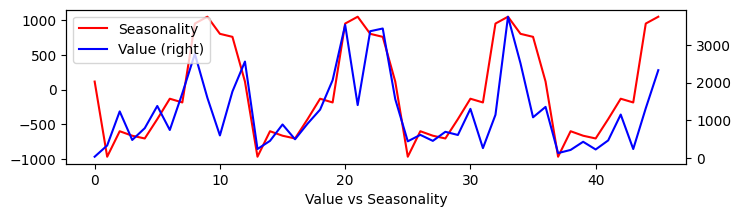

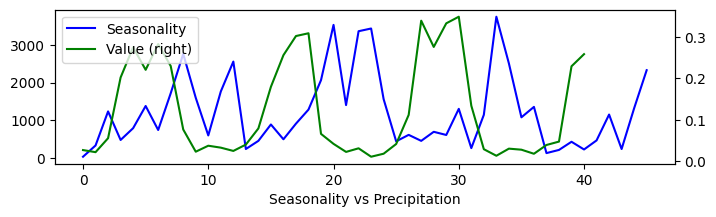

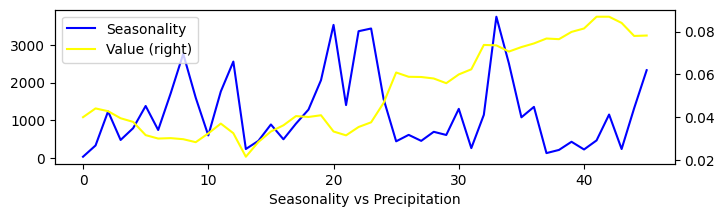

In [27]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,2))
plt.xlabel('Value vs Seasonality')

ax1 = ti.Season.plot(color='red', grid=False, label='Seasonality')
ax2 = ti.Value.plot(color='blue', grid=False, secondary_y=True, label='Value')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()
#############################################################################################
plt.figure(figsize=(8,2))
plt.xlabel('Seasonality vs Precipitation')

ax1 = ti.Value.plot(color='blue', grid=False, label='Value')
ax2 = ti['Precipitation (mm)'].plot(color='green', grid=False, secondary_y=True, label='Value')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()
#############################################################################################
plt.figure(figsize=(8,2))
plt.xlabel('Seasonality vs Precipitation')

ax1 = ti.Value.plot(color='blue', grid=False, label='Value')
ax2 = ti['Inflation Data'].plot(color='yellow', grid=False, secondary_y=True, label='Value')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()
